# Utilizing MCP

In [1]:
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [2]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

In [3]:
# MCP integration with Everything Server
mcp_image_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="/Users/badrinarayan/.local/bin/uv",  # Run MCP server via npx
            args=[
            "--directory",
            "/Users/badrinarayan/my_learning/img_gen",
            "run",
            "image_generation.py"
        ],
        ),
        timeout=60,
    )
)

print("✅ MCP Tool created")

✅ MCP Tool created


In [4]:
# Create image agent with MCP integration
image_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="image_agent",
    instruction="Use the MCP Tool to generate images for user queries",
    tools=[mcp_image_server],
)

In [5]:
from google.adk.runners import InMemoryRunner

runner = InMemoryRunner(agent=image_agent)

In [6]:
response = await runner.run_debug("Provide me an image of a cat", verbose=True)


 ### Created new session: debug_session_id

User > Provide me an image of a cat


/Users/badrinarayan/my_learning/google_adk/google-adk/lib/python3.11/site-packages/google/adk/tools/mcp_tool/mcp_tool.py:103: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(


image_agent > [Calling tool: generate_image({'prompt': 'A cat'})]
image_agent > [Tool result: {'content': [{'type': 'text', 'text': 'Generated image (image/jpeg, 121838 bytes):'}, {'type': 'imag...]
image_agent > Certainly! Here is an image of a cat.




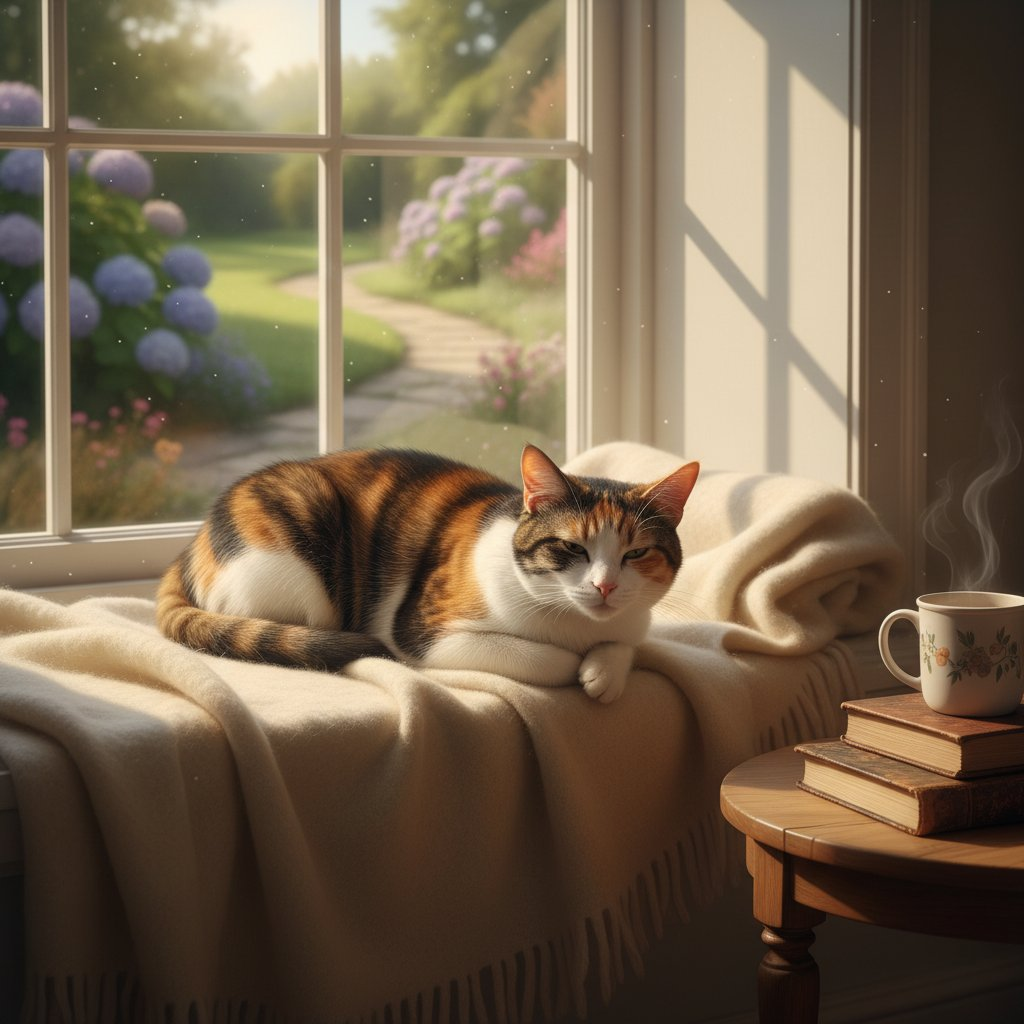

In [7]:
from IPython.display import display, Image as IPImage
import base64

for event in response:
    if event.content and event.content.parts:
        for part in event.content.parts:
            if hasattr(part, "function_response") and part.function_response:
                for item in part.function_response.response.get("content", []):
                    if item.get("type") == "image":
                        display(IPImage(data=base64.b64decode(item["data"])))

# HITL for multiple image generation

In [4]:
LARGE_IMAGE_THRESHOLD = 1


def request_image_generation(
    num_images: int, tool_context: ToolContext
) -> dict:
    """Requests image generation. Requires approval if generating more than 1 image (LARGE_IMAGE_THRESHOLD).

    Args:
        num_images: Number of images to generate

    Returns:
        Dictionary with status
    """

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 1: Small Requests (≤1 images) auto-approve
    if num_images <= LARGE_IMAGE_THRESHOLD:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_images}-AUTO",
            "num_images": num_images,
            "message": f"Request auto-approved: {num_images} images",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 2: This is the first time this tool is called. Large requests need human approval - PAUSE here.
    if not tool_context.tool_confirmation:
        tool_context.request_confirmation(
            hint=f"⚠️ Large Request: {num_images} images. Do you want to approve?",
            payload={"num_images": num_images},
        )
        return {  # This is sent to the Agent
            "status": "pending",
            "message": f"Request for {num_images} images requires approval",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 3: The tool is called AGAIN and is now resuming. Handle approval response - RESUME here.
    if tool_context.tool_confirmation.confirmed:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_images}-HUMAN",
            "num_images": num_images,
            "message": f"Requests approved: {num_images} images",
        }
    else:
        return {
            "status": "rejected",
            "message": f"Requests rejected: {num_images} images",
        }

print("✅ Long-running functions created!")

✅ Long-running functions created!


In [5]:
# Create request agent with pausable tool
image_request_agent = LlmAgent(
    name="image_request_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are an image request agent.
  
  When users request to generate image(s):
   1. Use the request_image_generation tool with the number of images
   2. If the Request status is 'pending', inform the user that approval is required
   3. Use mcp_image_server to generate the image(s) if request is approved
   4. After receiving the final result, provide a clear summary including:
      - Request status (approved/rejected)
      - Order ID (if available)
      - Number of images
   5. Keep responses concise but informative
  """,
    tools=[FunctionTool(func=request_image_generation), mcp_image_server],
)

print("✅ Shipping Agent created!")

✅ Shipping Agent created!


In [6]:
# Wrap the agent in a resumable app - THIS IS THE KEY FOR LONG-RUNNING OPERATIONS!
image_requesting_app = App(
    name="image_requesting_coordinator",
    root_agent=image_request_agent,
    resumability_config=ResumabilityConfig(is_resumable=True),
)

print("✅ Resumable app created!")

✅ Resumable app created!


/var/folders/38/c40htf2s2_j25fcx1xqc89hw0000gp/T/ipykernel_74440/2324390440.py:5: UserWarning: [EXPERIMENTAL] ResumabilityConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  resumability_config=ResumabilityConfig(is_resumable=True),


In [7]:
session_service = InMemorySessionService()

# Create runner with the resumable app
image_request_runner = Runner(
    app=image_requesting_app,  # Pass the app instead of the agent
    session_service=session_service,
)

print("✅ Runner created!")

✅ Runner created!


In [8]:
def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation"
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None

In [9]:
def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")

In [10]:
def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


print("✅ Helper functions defined")

✅ Helper functions defined


In [11]:
async def run_image_workflow(query: str, auto_approve: bool = True):
    """Runs a image workflow with approval handling.

    Args:
        query: User's shipping request
        auto_approve: Whether to auto-approve large orders (simulates human decision)
    """

    print(f"\n{'='*60}")
    print(f"User > {query}\n")

    # Generate unique session ID
    session_id = f"order_{uuid.uuid4().hex[:8]}"

    # Create session
    await session_service.create_session(
        app_name="image_requesting_coordinator", user_id="test_user", session_id=session_id
    )

    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    events = []

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 1: Send initial request to the Agent. If num_containers > 5, the Agent returns the special `adk_request_confirmation` event
    async for event in image_request_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 2: Loop through all the events generated and check if `adk_request_confirmation` is present.
    approval_info = check_for_approval(events)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 3: If the event is present, it's a large order - HANDLE APPROVAL WORKFLOW
    if approval_info:
        print(f"⏸️  Pausing for approval...")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")

        # PATH A: Resume the agent by calling run_async() again with the approval decision
        async for event in image_request_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(
                approval_info, auto_approve
            ),  # Send human decision here
            invocation_id=approval_info[
                "invocation_id"
            ],  # Critical: same invocation_id tells ADK to RESUME
        ):
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        print(f"Agent > {part.text}")

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    else:
        # PATH B: If the `adk_request_confirmation` is not present - no approval needed - order completed immediately.
        print_agent_response(events)

    print(f"{'='*60}\n")


print("✅ Workflow function ready")

✅ Workflow function ready


In [12]:
# Demo 1: It's a small order. Agent receives auto-approved status from tool
await run_image_workflow("Create an images of a cat")

# Demo 2: Workflow simulates human decision: APPROVE ✅
await run_image_workflow("Create two images of a cat", auto_approve=True)

# Demo 3: Workflow simulates human decision: REJECT ❌
await run_image_workflow("Create two different cat images", auto_approve=False)


User > Create an images of a cat



/Users/badrinarayan/my_learning/google_adk/google-adk/lib/python3.11/site-packages/google/adk/tools/mcp_tool/mcp_tool.py:103: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(


Agent > The image generation request has been approved. Here is the image of a cat.


User > Create two images of a cat



/Users/badrinarayan/my_learning/google_adk/google-adk/lib/python3.11/site-packages/google/adk/tools/tool_context.py:92: UserWarning: [EXPERIMENTAL] ToolConfirmation: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  ToolConfirmation(
/Users/badrinarayan/my_learning/google_adk/google-adk/lib/python3.11/site-packages/google/adk/agents/invocation_context.py:302: UserWarning: [EXPERIMENTAL] BaseAgentState: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  self.agent_states[event.author] = BaseAgentState()


⏸️  Pausing for approval...
🤔 Human Decision: APPROVE ✅



Agent > The image generation request has been approved. Two images of a cat have been generated.


User > Create two different cat images



⏸️  Pausing for approval...
🤔 Human Decision: REJECT ❌

Agent > The request to generate 2 images has been rejected.

